# Better Parsing: Ingest

* Ingest Pipeline:
    * Unstructured PDF parsing
    * Page chunking and indexing
* Query Pipeline
    * Basic retriver

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
from pathlib import Path
import pickle

from dotenv import load_dotenv
import pandas as pd
from ragas.evaluation import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_relevancy,
    context_recall,
    context_precision,
)

from langchain_community.document_loaders import PyPDFLoader
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma

from src import chain, tags, rag_eval

from src.mle import utils as mle_utils

C:\Users\manua\.conda\envs\rag-advanced\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import sys

sys.executable

'C:\\Users\\manua\\.conda\\envs\\rag-advanced\\python.exe'

# Params

In [4]:
id_pipeline = "02parseunstr"
folder_src = "ai-papers"
index_name = "ai-papers-2.0"
llm_emb = "text-embedding-3-small"
retriever_k = 2
retriever_treshold = 0.3
temp = 0.2
llm_model = "gpt-4o-mini"

In [100]:
path_eval_ds = mle_utils.path_data_raw / "eval-questions" 
fln_eval_ds = path_eval_ds / f"{folder_src}.csv"
fln_eval_ds

WindowsPath('c:/users/manua/documents/repos/dslabs/rag-advanced/data/raw/eval-questions/ai-papers.csv')

In [94]:
load_dotenv()
embeddings = OpenAIEmbeddings(model=llm_emb)
llm = ChatOpenAI(model_name=llm_model, temperature=temp)
llm_eval = ChatOpenAI(model_name=llm_model, temperature=0.1)


path_corpus = mle_utils.path_data_raw / folder_src 

path_unstructured = mle_utils.path_data_interm / "parsed-unstructured"
path_unstructured.mkdir(exist_ok=True, parents=True)

path_db = mle_utils.path_data_interm / folder_src / "chroma_langchain_db"
path_db.mkdir(exist_ok=True, parents=True)

path_eval_ds = mle_utils.path_data_raw / "eval-questions" 
fln_eval_ds = path_eval_ds / f"{index_name}.csv"


path_eval = mle_utils.path_data_processed /  "evals" / index_name
path_eval.mkdir(exist_ok=True, parents=True)
fln_eval_ragas = path_eval / f"ragas-{id_pipeline}.pkl"

# Parse

In [8]:
import os

from unstructured_ingest.v2.pipeline.pipeline import Pipeline
from unstructured_ingest.v2.interfaces import ProcessorConfig
from unstructured_ingest.v2.processes.connectors.local import (
    LocalIndexerConfig,
    LocalDownloaderConfig,
    LocalConnectionConfig,
    LocalUploaderConfig
)
from unstructured_ingest.v2.processes.partitioner import PartitionerConfig

input_path = path_corpus 
output_dir = path_unstructured

Pipeline.from_configs(
    context=ProcessorConfig(),
    indexer_config=LocalIndexerConfig(input_path=input_path.as_posix()),
    downloader_config=LocalDownloaderConfig(),
    source_connection_config=LocalConnectionConfig(),
    partitioner_config=PartitionerConfig(
        partition_by_api=True,
        api_key=os.getenv("UNSTRUCTURED_API_KEY"),
        partition_endpoint=os.getenv("UNSTRUCTURED_API_URL"),
        strategy="hi_res",
        additional_partition_args={
            "split_pdf_page": True,
            "split_pdf_allow_failed": True,
            "split_pdf_concurrency_level": 15
        }
    ),
    uploader_config=LocalUploaderConfig(output_dir=output_dir.as_posix())
).run()


Overriding of current TracerProvider is not allowed
2024-09-21 16:29:30,914 MainProcess INFO     created index with configs: {"input_path": "c:\\users\\manua\\documents\\repos\\dslabs\\rag-advanced\\data\\raw\\ai-papers", "recursive": false}, connection configs: {"access_config": "**********"}
2024-09-21 16:29:30,916 MainProcess INFO     Created download with configs: {"download_dir": null}, connection configs: {"access_config": "**********"}
2024-09-21 16:29:30,918 MainProcess INFO     created partition with configs: {"strategy": "hi_res", "ocr_languages": null, "encoding": null, "additional_partition_args": {"split_pdf_page": true, "split_pdf_allow_failed": true, "split_pdf_concurrency_level": 15}, "skip_infer_table_types": null, "fields_include": ["element_id", "text", "type", "metadata", "embeddings"], "flatten_metadata": false, "metadata_exclude": [], "metadata_include": [], "partition_endpoint": null, "partition_by_api": true, "api_key": "*******", "hi_res_model_name": null}
2024

In [546]:
from unstructured.staging.base import elements_from_json

def load_processed_files(directory_path):
    elements = []
    for filename in os.listdir(directory_path):
        if filename.endswith('.json'):
            file_path = os.path.join(directory_path, filename)
            try:
                elements.extend(elements_from_json(filename=file_path))
            except IOError:
                print(f"Error: Could not read file {filename}.")

    return elements

elements = load_processed_files(output_dir.as_posix())

In [278]:
elements[0].to_dict()

{'type': 'Title',
 'element_id': 'f511938b5e0cde9b60b2daa56ff54d8d',
 'text': 'ColPali: Efficient Document Retrieval with Vision Language Models',
 'metadata': {'filetype': 'application/pdf',
  'languages': ['eng'],
  'page_number': 1,
  'filename': 'colpali.pdf',
  'data_source': {'record_locator': {'path': 'C:\\Users\\manua\\Documents\\repos\\dslabs\\rag-advanced\\data\\raw\\ai-papers\\colpali.pdf'},
   'date_modified': '1726516253.7777264',
   'date_processed': '1726928971.255982',
   'permissions_data': [{'mode': 33206}]}}}

In [279]:
elements[0].metadata.filename

'colpali.pdf'

In [280]:
lst_sources = [x.name for x in path_corpus.iterdir()]
lst_sources

['colpali.pdf',
 'lagllama.pdf',
 'llama3herd.pdf',
 'mamba.pdf',
 'paligemma.pdf',
 'timesfm.pdf']

In [302]:
elements[0].

'Title'

In [298]:
elements[0].to_dict()

{'type': 'Title',
 'element_id': 'f511938b5e0cde9b60b2daa56ff54d8d',
 'text': 'ColPali: Efficient Document Retrieval with Vision Language Models',
 'metadata': {'filetype': 'application/pdf',
  'languages': ['eng'],
  'page_number': 1,
  'filename': 'colpali.pdf',
  'data_source': {'record_locator': {'path': 'C:\\Users\\manua\\Documents\\repos\\dslabs\\rag-advanced\\data\\raw\\ai-papers\\colpali.pdf'},
   'date_modified': '1726516253.7777264',
   'date_processed': '1726928971.255982',
   'permissions_data': [{'mode': 33206}]}}}

In [547]:
def elements_to_dataframe(elements):
    lst_elements = []
    for element in elements:
        e_metadata = element.metadata
        row = {}
        row['id'] = element.id
        row['text'] = element.text
        row['type'] = element.__class__.__name__
        row['len'] = len(element.text)
        row['page_number'] = e_metadata.page_number
        row['source'] = e_metadata.filename
        row['parent_id'] = e_metadata.parent_id
        row['main_lang'] = e_metadata.languages[0]

        lst_elements.append(row)
    return pd.DataFrame(lst_elements)

df_elements = elements_to_dataframe(elements)
df_elements["element_number"] = df_elements.groupby("source").cumcount()
df_elements[:10]

,id,text,type,len,page_number,source,parent_id,main_lang,element_number
0,f511938b5e0cde9b60b2daa56ff54d8d,ColPali: Efficient Document Retrieval with Vis...,Title,65,1,colpali.pdf,None,eng,0
1,68b40c6d81c39afed36254bd4ad10a25,"Manuel Faysse* 1,3 Hugues Sibille∗1,4 Tony Wu∗...",Title,61,1,colpali.pdf,None,eng,1
2,434a14b09b580130cacf99de2b4e8098,Gautier Viaud1 Céline Hudelot3,Title,30,1,colpali.pdf,None,eng,2
3,4d08e6af924ec4f2d8c3ad7f202b970d,1Illuin Technology 2Equall.ai,NarrativeText,29,1,colpali.pdf,434a14b09b580130cacf99de2b4e8098,eng,3
4,808d2178a8a4651d5ee1e1e29ad01aa3,"3CentraleSupélec, Paris-Saclay 4ETH Zürich",NarrativeText,42,1,colpali.pdf,434a14b09b580130cacf99de2b4e8098,eng,4
5,aba79745a3d38d700b7d47d350cf3497,manuel.faysse@centralesupelec.fr,NarrativeText,32,1,colpali.pdf,434a14b09b580130cacf99de2b4e8098,eng,5
6,c41da8724188848db449496300ac8f6b,"Pierre Colombo2,3",Title,17,1,colpali.pdf,None,eng,6
7,f6400ed438b4f408567b16f722798490,4 2 0 2 l u J 2 ] R I . s c [ 2 v 9 4 4 1 0 . ...,NarrativeText,65,1,colpali.pdf,c41da8724188848db449496300ac8f6b,eng,7
8,e315a97e6b65c26710e269a0c6e6fa72,Abstract,Title,8,1,colpali.pdf,None,eng,8
9,25dc43d27e394bbedfa275070eaeb79b,Documents are visually rich structures that co...,NarrativeText,1178,1,colpali.pdf,e315a97e6b65c26710e269a0c6e6fa72,eng,9


In [438]:
elements[0].to_dict()

{'type': 'Title',
 'element_id': 'f511938b5e0cde9b60b2daa56ff54d8d',
 'text': 'ColPali: Efficient Document Retrieval with Vision Language Models',
 'metadata': {'filetype': 'application/pdf',
  'languages': ['eng'],
  'page_number': 1,
  'filename': 'colpali.pdf',
  'data_source': {'record_locator': {'path': 'C:\\Users\\manua\\Documents\\repos\\dslabs\\rag-advanced\\data\\raw\\ai-papers\\colpali.pdf'},
   'date_modified': '1726516253.7777264',
   'date_processed': '1726928971.255982',
   'permissions_data': [{'mode': 33206}]}}}

In [439]:
elements[8].to_dict()

{'type': 'Title',
 'element_id': 'e315a97e6b65c26710e269a0c6e6fa72',
 'text': 'Abstract',
 'metadata': {'filetype': 'application/pdf',
  'languages': ['eng'],
  'page_number': 1,
  'filename': 'colpali.pdf',
  'data_source': {'record_locator': {'path': 'C:\\Users\\manua\\Documents\\repos\\dslabs\\rag-advanced\\data\\raw\\ai-papers\\colpali.pdf'},
   'date_modified': '1726516253.7777264',
   'date_processed': '1726928971.255982',
   'permissions_data': [{'mode': 33206}]}}}

In [440]:
elements[9].to_dict()

{'type': 'NarrativeText',
 'element_id': '25dc43d27e394bbedfa275070eaeb79b',
 'text': 'Documents are visually rich structures that con- vey information through text, as well as tables, figures, page layouts, or fonts. While mod- ern document retrieval systems exhibit strong performance on query-to-text matching, they struggle to exploit visual cues efficiently, hin- dering their performance on practical document retrieval applications such as Retrieval Aug- mented Generation. To benchmark current sys- tems on visually rich document retrieval, we in- troduce the Visual Document Retrieval Bench- mark ViDoRe, composed of various page-level retrieving tasks spanning multiple domains, languages, and settings. The inherent short- comings of modern systems motivate the in- troduction of a new retrieval model architec- ture, ColPali, which leverages the document understanding capabilities of recent Vision Lan- guage Models to produce high-quality contextu- alized embeddings solely from images 

In [441]:
elements[29].to_dict()

{'type': 'Title',
 'element_id': '2ec51fb1abf88787d77ef41e9544e06b',
 'text': '2.1 Textual Retrieval Methods',
 'metadata': {'filetype': 'application/pdf',
  'languages': ['eng'],
  'page_number': 2,
  'filename': 'colpali.pdf',
  'data_source': {'record_locator': {'path': 'C:\\Users\\manua\\Documents\\repos\\dslabs\\rag-advanced\\data\\raw\\ai-papers\\colpali.pdf'},
   'date_modified': '1726516253.7777264',
   'date_processed': '1726928971.255982',
   'permissions_data': [{'mode': 33206}]}}}

In [442]:
df_elements.query("text == '5 Results'")

,id,text,type,len,page_number,source,parent_id,main_lang,el_number
65,1dcc188d9acb7903c8a946847e58a69c,5 Results,Title,9,6,colpali.pdf,None,eng,1
1119,bec10c1db208e1a0c6f6ff824492b59f,5 Results,Title,9,28,llama3herd.pdf,None,eng,1


In [443]:
elements[65].to_dict()

{'type': 'Title',
 'element_id': '1dcc188d9acb7903c8a946847e58a69c',
 'text': '5 Results',
 'metadata': {'filetype': 'application/pdf',
  'languages': ['eng'],
  'page_number': 6,
  'filename': 'colpali.pdf',
  'data_source': {'record_locator': {'path': 'C:\\Users\\manua\\Documents\\repos\\dslabs\\rag-advanced\\data\\raw\\ai-papers\\colpali.pdf'},
   'date_modified': '1726516253.7777264',
   'date_processed': '1726928971.255982',
   'permissions_data': [{'mode': 33206}]}}}

In [444]:
elements[66].to_dict()

{'type': 'Title',
 'element_id': '8b858e2d33962a85c032f4ed047386bb',
 'text': '5.1 Performance (R1)',
 'metadata': {'filetype': 'application/pdf',
  'languages': ['eng'],
  'page_number': 6,
  'filename': 'colpali.pdf',
  'data_source': {'record_locator': {'path': 'C:\\Users\\manua\\Documents\\repos\\dslabs\\rag-advanced\\data\\raw\\ai-papers\\colpali.pdf'},
   'date_modified': '1726516253.7777264',
   'date_processed': '1726928971.255982',
   'permissions_data': [{'mode': 33206}]}}}

In [445]:
df_elements['type'].value_counts()

type
NarrativeText    2362
Title             455
Image             216
PageNumber        212
Text              134
Header             91
Table              88
Formula            25
ListItem           22
CodeSnippet         9
Footer              2
Name: count, dtype: int64

In [446]:
df_elements.query("type == 'Image'").head(2)

,id,text,type,len,page_number,source,parent_id,main_lang,el_number
15,5d7568347deb44201f99363c0023f35d,"nnn 17 N Yo N Query: ""Which hour of the day ha...",Image,99,1,colpali.pdf,None,eng,1
20,a346d7936ba3a2c326f883e1a09bfcb5,~ / Standard Retrieval #if 0.66 NDCG@5 offline...,Image,259,2,colpali.pdf,None,eng,1


In [447]:
elements[15].to_dict()

{'type': 'Image',
 'element_id': '5d7568347deb44201f99363c0023f35d',
 'text': 'nnn 17 N Yo N Query: "Which hour of the day had the highest overall eletricity generation in 20197"',
 'metadata': {'filetype': 'application/pdf',
  'languages': ['eng'],
  'page_number': 1,
  'filename': 'colpali.pdf',
  'data_source': {'record_locator': {'path': 'C:\\Users\\manua\\Documents\\repos\\dslabs\\rag-advanced\\data\\raw\\ai-papers\\colpali.pdf'},
   'date_modified': '1726516253.7777264',
   'date_processed': '1726928971.255982',
   'permissions_data': [{'mode': 33206}]}}}

In [448]:
df_elements.query("type == 'Table'").head(2)

,id,text,type,len,page_number,source,parent_id,main_lang,el_number
41,1b6f97ab625d862f83bdb5414085f6d5,Dataset # Queries Domain Academic Tasks DocVQA...,Table,433,4,colpali.pdf,45c3225d9bc640b87d790f8ba031ce5a,eng,1
75,c0c1aa514861452d8fdc9041b28b1340,ArxivQ DocQ InfoQ TabF TATQ Shift AI Energy Go...,Table,1280,7,colpali.pdf,None,eng,1


In [449]:
elements[41].to_dict()

{'type': 'Table',
 'element_id': '1b6f97ab625d862f83bdb5414085f6d5',
 'text': 'Dataset # Queries Domain Academic Tasks DocVQA (eng) InfoVQA (eng) TAT-DQA (eng) arXiVQA (eng) TabFQuAD (fra) 500 (500) 500 (500) 1600 (1600) Varied Modalities Scientific Figures 500 (500) Tables 210 (210) Industrial Infographics Practical Tasks Energy (eng) Government (eng) Healthcare (eng) AI (eng) Shift Project (fra) 100 (1000) 100 (1000) 100 (1000) 100 (1000) 100 (1000) Scientific Administrative Medical Scientific Environment',
 'metadata': {'text_as_html': '<table><thead><tr><th>Dataset</th><th># Queries</th><th>Domain</th></tr></thead><tbody><tr><td colspan="3">Academic Tasks</td></tr><tr><td>DocVQA (eng)</td><td>500 (500)</td><td>Industrial</td></tr><tr><td>InfoVQA (eng)</td><td>500 (500)</td><td>Infographics</td></tr><tr><td>TAT-DQA (eng)</td><td>1600 (1600)</td><td>Varied Modalities</td></tr><tr><td>arXiVQA (eng)</td><td>500 (500)</td><td>Scientific Figures</td></tr><tr><td>TabFQuAD (fra)</td><td>21

In [450]:
df_elements.query("type == 'Formula'").head(2)

,id,text,type,len,page_number,source,parent_id,main_lang,el_number
59,10d851aeed9bf26db5f14e7fa68ab8aa,"Li(g,d)= max (Eq(i) \Ed(j)> 1) i€[|1,Ng]] Jell...",Formula,52,5,colpali.pdf,None,eng,1
187,7f4db1f28453fb634c30ba94d08d0c2a,L= %gsoftplus (s; - sz),Formula,23,14,colpali.pdf,None,eng,1


In [451]:
elements[59].to_dict()

{'type': 'Formula',
 'element_id': '10d851aeed9bf26db5f14e7fa68ab8aa',
 'text': 'Li(g,d)= max (Eq(i) \\Ed(j)> 1) i€[|1,Ng]] JellL,Nal]',
 'metadata': {'filetype': 'application/pdf',
  'languages': ['eng'],
  'page_number': 5,
  'filename': 'colpali.pdf',
  'data_source': {'record_locator': {'path': 'C:\\Users\\manua\\Documents\\repos\\dslabs\\rag-advanced\\data\\raw\\ai-papers\\colpali.pdf'},
   'date_modified': '1726516253.7777264',
   'date_processed': '1726928971.255982',
   'permissions_data': [{'mode': 33206}]}}}

In [452]:
df_elements.query("type == 'ListItem'").head()

,id,text,type,len,page_number,source,parent_id,main_lang,el_number
292,e01ebec18ba385f168d8a8ac46713e6e,!,ListItem,1,19,colpali.pdf,eff1430a7cd66a284236c4eba3d98932,eng,1
296,2ad19ed1fcf3b143a5565abf1b69c841,l,ListItem,1,19,colpali.pdf,6b114bf8ae8f8546128343e4ac43045d,eng,1
354,df0b335876e317170942c242e0c3bee6,Kashif Rasul 1 *Arjun Ashok 2 3 4 ♢Andrew Robe...,ListItem,370,1,lagllama.pdf,a1ecf949a03898dea2f663e058de17d9,eng,1
369,86e29c14d26f682db01cf164e000fba0,Lag-Llama also demonstrates state-of-the-art p...,ListItem,541,2,lagllama.pdf,019d5c343a01b45a2a202f4e14530b91,eng,1
766,d7e107d327e3fd8ef8df40f6b8554a63,We use a fasttext-based language identificatio...,ListItem,186,5,llama3herd.pdf,None,eng,1


In [453]:
elements[354].to_dict()

{'type': 'ListItem',
 'element_id': 'df0b335876e317170942c242e0c3bee6',
 'text': 'Kashif Rasul 1 *Arjun Ashok 2 3 4 ♢Andrew Robert Williams 3 4 ♢Hena Ghonia 3 4 Rishika Bhagwatkar 3 4 ♠Arian Khorasani 3 4 ♠Mohammad Javad Darvishi Bayazi 3 ♠George Adamopoulos 5 ♠Roland Riachi 3 4 Nadhir Hassen 3 4 Marin Biloˇs 1 △Sahil Garg 1 △Anderson Schneider 1 △Nicolas Chapados 2 4 △Alexandre Drouin 2 4 △Valentina Zantedeschi 2 ♣Yuriy Nevmyvaka 1 ♣Irina Rish 3 4',
 'metadata': {'filetype': 'application/pdf',
  'languages': ['eng'],
  'page_number': 1,
  'parent_id': 'a1ecf949a03898dea2f663e058de17d9',
  'filename': 'lagllama.pdf',
  'data_source': {'record_locator': {'path': 'C:\\Users\\manua\\Documents\\repos\\dslabs\\rag-advanced\\data\\raw\\ai-papers\\lagllama.pdf'},
   'date_modified': '1726302051.844055',
   'date_processed': '1726928971.2710156',
   'permissions_data': [{'mode': 33206}]}}}

In [454]:
df_elements.query("type == 'CodeSnippet'").head(2)

,id,text,type,len,page_number,source,parent_id,main_lang,el_number
176,748b2b48dfeec98c616c1950ad61cb35,"{ ""questions”: [ { ""question”: ""XXXXXX"", ""answ...",CodeSnippet,274,13,colpali.pdf,None,eng,1
947,812e0849623a355479a4b0a610928839,def gushti_cdi(): n = - int (input()) arr - Z ...,CodeSnippet,216,21,llama3herd.pdf,None,eng,1


In [455]:
elements[947].to_dict()

{'type': 'CodeSnippet',
 'element_id': '812e0849623a355479a4b0a610928839',
 'text': 'def gushti_cdi(): n = - int (input()) arr - Z list(map(int, input().split())) points - - 0 for i in range(n): if arr(i] Z = == 0 and i != 0: idx arr.index(max(arr[:i])) points += arr[idx] arr[idx] - = 0 return points',
 'metadata': {'filetype': 'application/pdf',
  'languages': ['eng'],
  'page_number': 21,
  'filename': 'llama3herd.pdf',
  'data_source': {'record_locator': {'path': 'C:\\Users\\manua\\Documents\\repos\\dslabs\\rag-advanced\\data\\raw\\ai-papers\\llama3herd.pdf'},
   'date_modified': '1726516319.128451',
   'date_processed': '1726928971.2891052',
   'permissions_data': [{'mode': 33206}]}}}

In [456]:
df_elements.query("type == 'Footer'").head(2)

,id,text,type,len,page_number,source,parent_id,main_lang,el_number
350,87645f4e5c0364c03df2286b76fdbd38,[R—— O,Footer,6,20,colpali.pdf,None,eng,1
2535,b975f22305009ee8dccbd186b545b254,"Corresponding author(s): lbeyer,xzhai@google.c...",Footer,92,1,paligemma.pdf,None,eng,1


In [321]:
df_elements.query("type == 'PageNumber'").head(2)

,id,text,type,len,page_number,source,parent_id,main_lang
27,c39760c7eaa903fffdc3c6b4a280f101,2,PageNumber,1,2,colpali.pdf,None,eng
34,bb187bf63155fc6a84e27d588179b209,3,PageNumber,1,3,colpali.pdf,None,eng


# Cleaning

## Filter Correct Titles

In [457]:
lst_titles_candidates_colpali = (df_elements
 .query("type == 'Title'")
 .query("source == 'colpali.pdf'")
 .apply(
    lambda row: f"id: {row['id']} | page_number: {row['page_number']} | text: {row['text']}"
    , axis=1)
)

lst_titles_candidates_colpali[:2]

0    id: f511938b5e0cde9b60b2daa56ff54d8d | page_nu...
1    id: 68b40c6d81c39afed36254bd4ad10a25 | page_nu...
dtype: object

In [520]:
df_elements.tail()

,id,text,type,len,page_number,source,parent_id,main_lang,element_number
3611,a1650e2b47900e10819fdcab84756551,"• ARMA(p, q) (II), where 1 ≤ p, q ≤ 8 and the ...",NarrativeText,153,13,timesfm.pdf,f83f566faf86915ff4d4d1de6093b790,eng,211
3612,b6f3e798e239bdc7138063f21f615573,• Seasonal patterns. In particular we create t...,NarrativeText,159,13,timesfm.pdf,f83f566faf86915ff4d4d1de6093b790,eng,212
3613,7cd1ca08ca42500e7d510c27a1aff00c,We then randomly enable / disable these four c...,NarrativeText,332,13,timesfm.pdf,f83f566faf86915ff4d4d1de6093b790,eng,213
3614,681fb44a024c9c1c1a9b7f53a488be81,6https://github.com/ngruver/llmtime/blob/main/...,NarrativeText,71,13,timesfm.pdf,f83f566faf86915ff4d4d1de6093b790,eng,214
3615,d7314c21900607ec1284025194b2499b,13,PageNumber,2,13,timesfm.pdf,None,eng,215


In [526]:
def get_titles_candidates_by_source(df_elements, sources):
    dc_titles_candidates_by_source = {}
    for source in sources:
        dc_titles_candidates_by_source[source] = (df_elements
         .query("source == @source")
         .query("type == 'Title'")
         .apply(
            lambda row: f"id: {row['id']} | page_number: {row['page_number']} | text: {row['text']}"
            , axis=1)
        ).tolist()
    return dc_titles_candidates_by_source

dc_titles_candidates_by_source = get_titles_candidates_by_source(df_elements, lst_sources)

dc_titles_candidates_by_source['colpali.pdf'][0]

'id: f511938b5e0cde9b60b2daa56ff54d8d | page_number: 1 | text: ColPali: Efficient Document Retrieval with Vision Language Models'

In [528]:
dc_titles_candidates_by_source['timesfm.pdf'][0]

'id: 066bae156e29e17fd18354f79e830bf8 | page_number: 1 | text: A decoder-only foundation model for time-series forecasting'

In [144]:
expected_examples_json = [
  {
    "id": "f11111",
    "page": 1,
    "title": "Cool Paper To Some Machine Learning Model",
    "number": None,
    "parent_title_id": None
  },
  {
    "id": "f11113",
    "page": 1,
    "title": "Intro",
    "number": None,
    "parent_title_id": "f11111"
  },
  {
    "id": "f11114",
    "page": 1,
    "title": "1 What is new with this ML model",
    "number": "1",
    "parent_title_id": "f11111"
  },
  {
    "id": "f11115",
    "page": 1,
    "title": "1.a Previous Work",
    "number": "1.a",
    "parent_title_id": "f11114"
  }
]

In [145]:
prompt_template = """
I have parsed a PDF document and extracted potential title candidates. 
I need you to determine which items are actual titles and their relationships (sections or subsections) if any.
Each item is on format:
``` 
id: f51193 page: 1
text: text to analyze whether it is actually a title
```
If a title includes section/subsection numbers, please extract these.
For the output, return a JSON format with the following fields for each item:
```
id: the input ID
page: the input page number
title: the text (if determined to be a title)
number: section/subsection number (if any)
parent_title_id: the ID of the parent title (for subsections), if applicable.
```
Use the provided examples as a reference. If an item is not a title, it should be excluded from the result.

Examples:
```
id f11111 | page_number: 1 |  text: Cool Paper To Some Machine Learning Model
id f11112 | page_number: 1 | text: Manuel Romero y otra gente
id f11113 | page_number: 1 | text: Intro
id f11114 | page_number: 2 | text: 1 What is new with this ML model
id f11115 | page_number: 2 | text: 1.a Previous Work
```

Expected Output:
```
{expected_examples_json}
```

Instructions:
For each text item, determine if it is an actual title.
Extract section/subsection numbers if available.
Identify hierarchical relationships by associating subsections with parent sections, using the parent_title_id field.
If the item is not a title, it should not appear in the output.
REmember to yield an ouptut in json format

Items: 
{items}
"""
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
prompt = PromptTemplate.from_template(prompt_template)

prompt.invoke({"items":"abc", "expected_examples_json": expected_examples_json})

StringPromptValue(text="\nI have parsed a PDF document and extracted potential title candidates. \nI need you to determine which items are actual titles and their relationships (sections or subsections) if any.\nEach item is on format:\n``` \nid: f51193 page: 1\ntext: text to analyze whether it is actually a title\n```\nIf a title includes section/subsection numbers, please extract these.\nFor the output, return a JSON format with the following fields for each item:\n```\nid: the input ID\npage: the input page number\ntitle: the text (if determined to be a title)\nnumber: section/subsection number (if any)\nparent_title_id: the ID of the parent title (for subsections), if applicable.\n```\nUse the provided examples as a reference. If an item is not a title, it should be excluded from the result.\n\nExamples:\n```\nid f11111 | page_number: 1 |  text: Cool Paper To Some Machine Learning Model\nid f11112 | page_number: 1 | text: Manuel Romero y otra gente\nid f11113 | page_number: 1 | tex

In [ ]:
dc_elements_by_source

In [148]:
# This Runnable takes a dict with keys 'input' and 'context',
# formats them into a prompt, and generates a response.
from langchain_core.runnables import RunnablePassthrough

chain_detect_titles = (
    # https://github.com/langchain-ai/langchain/issues/1660
    {"expected_examples_json": lambda x: expected_examples_json, "items": RunnablePassthrough()}
    | prompt  
    | llm 
    | JsonOutputParser()
                      )

lst_titles_candidates_colpali = dc_titles_candidates_by_source['colpali.pdf']
str_titles_candidates_colpali = "\n".join(lst_titles_candidates_colpali)
lst_titles_colpali = chain_detect_titles.invoke({"items": str_titles_candidates_colpali})

INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [514]:
dc_titles_candidates_by_source[source]

'id: f511938b5e0cde9b60b2daa56ff54d8d | page_number: 1 | text: ColPali: Efficient Document Retrieval with Vision Language Models'

In [529]:
dc_titles_by_source = {}
dc_titles_by_source["colpali.pdf"] = lst_titles_colpali

for source in lst_sources:
    if source != "colpali.pdf":
        lst_titles_candidates = dc_titles_candidates_by_source[source]
        str_titles_candidates = "\n".join(lst_titles_candidates)
        lst_titles = chain_detect_titles.invoke({"items": str_titles_candidates})
        dc_titles_by_source[source] = lst_titles

        

INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [530]:
dc_titles_by_source['lagllama.pdf'][:2]

[{'id': 'a1ecf949a03898dea2f663e058de17d9',
  'page': 1,
  'title': 'Lag-Llama: Towards Foundation Models for Probabilistic Time Series Forecasting',
  'number': None,
  'parent_title_id': None},
 {'id': '8cbd99db910252adc28963e0e8930bcc',
  'page': 1,
  'title': 'Abstract',
  'number': None,
  'parent_title_id': 'a1ecf949a03898dea2f663e058de17d9'}]

In [531]:
dc_titles_by_source['llama3herd.pdf'][:2]

[{'id': '271b1eb9e81587da4ac08a1b5f95d668',
  'page': 1,
  'title': '1 Introduction',
  'number': '1',
  'parent_title_id': None},
 {'id': '978116a59639f0ca36e33eddb6e5d807',
  'page': 3,
  'title': '2 General Overview',
  'number': '2',
  'parent_title_id': None}]

In [532]:
import numpy as np

In [552]:
df_elements = elements_to_dataframe(elements)
df_elements["element_number"] = df_elements.groupby("source").cumcount()

In [553]:
def clean_titles(df_elements, sources, titles_by_source):

    lst_elements_by_source = []
    for source in sources:
        df_elements_colpali = df_elements.query("source == @source") .copy()

        # set parent_id in Titles
        lst_titles_colpali = titles_by_source[source]
        se_titles_colpalli = pd.DataFrame(lst_titles_colpali).set_index('id')['parent_title_id'].rename("parent_id_fixed")
        df_elements_colpali = df_elements_colpali.merge(se_titles_colpalli, how="left", left_on="id", right_on="id")

        # set parent_id everywhere else
        se_parent_id_fixed = pd.Series(
            index=df_elements_colpali.index,
            data=np.where(
                    df_elements_colpali['parent_id'].isin(set([x['id'] for x in lst_titles_colpali])),
                    df_elements_colpali['parent_id'],
                    None
                )
            )
        df_elements_colpali['parent_id_fixed'] = df_elements_colpali['parent_id_fixed'].fillna(se_parent_id_fixed).ffill()
        
        df_elements_colpali = (df_elements_colpali
                               .drop(columns=['parent_id'])
                               .rename(columns=
                                       {"parent_id_fixed": "parent_id"})
                              )
        lst_elements_by_source.append(df_elements_colpali)
        
    return pd.concat(lst_elements_by_source, axis=0, names=['source'])

df_elements = clean_titles(df_elements, lst_sources, dc_titles_by_source)
df_elements.head(5)

,id,text,type,len,page_number,source,main_lang,element_number,parent_id
0,f511938b5e0cde9b60b2daa56ff54d8d,ColPali: Efficient Document Retrieval with Vis...,Title,65,1,colpali.pdf,eng,0,None
1,68b40c6d81c39afed36254bd4ad10a25,"Manuel Faysse* 1,3 Hugues Sibille∗1,4 Tony Wu∗...",Title,61,1,colpali.pdf,eng,1,None
2,434a14b09b580130cacf99de2b4e8098,Gautier Viaud1 Céline Hudelot3,Title,30,1,colpali.pdf,eng,2,None
3,4d08e6af924ec4f2d8c3ad7f202b970d,1Illuin Technology 2Equall.ai,NarrativeText,29,1,colpali.pdf,eng,3,None
4,808d2178a8a4651d5ee1e1e29ad01aa3,"3CentraleSupélec, Paris-Saclay 4ETH Zürich",NarrativeText,42,1,colpali.pdf,eng,4,None


In [554]:
df_elements.head(10)

,id,text,type,len,page_number,source,main_lang,element_number,parent_id
0,f511938b5e0cde9b60b2daa56ff54d8d,ColPali: Efficient Document Retrieval with Vis...,Title,65,1,colpali.pdf,eng,0,None
1,68b40c6d81c39afed36254bd4ad10a25,"Manuel Faysse* 1,3 Hugues Sibille∗1,4 Tony Wu∗...",Title,61,1,colpali.pdf,eng,1,None
2,434a14b09b580130cacf99de2b4e8098,Gautier Viaud1 Céline Hudelot3,Title,30,1,colpali.pdf,eng,2,None
3,4d08e6af924ec4f2d8c3ad7f202b970d,1Illuin Technology 2Equall.ai,NarrativeText,29,1,colpali.pdf,eng,3,None
4,808d2178a8a4651d5ee1e1e29ad01aa3,"3CentraleSupélec, Paris-Saclay 4ETH Zürich",NarrativeText,42,1,colpali.pdf,eng,4,None
5,aba79745a3d38d700b7d47d350cf3497,manuel.faysse@centralesupelec.fr,NarrativeText,32,1,colpali.pdf,eng,5,None
6,c41da8724188848db449496300ac8f6b,"Pierre Colombo2,3",Title,17,1,colpali.pdf,eng,6,None
7,f6400ed438b4f408567b16f722798490,4 2 0 2 l u J 2 ] R I . s c [ 2 v 9 4 4 1 0 . ...,NarrativeText,65,1,colpali.pdf,eng,7,None
8,e315a97e6b65c26710e269a0c6e6fa72,Abstract,Title,8,1,colpali.pdf,eng,8,f511938b5e0cde9b60b2daa56ff54d8d
9,25dc43d27e394bbedfa275070eaeb79b,Documents are visually rich structures that co...,NarrativeText,1178,1,colpali.pdf,eng,9,e315a97e6b65c26710e269a0c6e6fa72


In [564]:
master = set([x['id'] for x in dc_titles_by_source['colpali.pdf']])
len(master)

35

In [561]:
df_elements_colpali = df_elements.query("source == 'colpali.pdf'")
detail = set(df_elements_colpali['parent_id'].tolist())
len(detail)

36

In [562]:
master.difference(detail)

set()

In [563]:
detail.difference(master)

{None}

## Filter Short Narratives

In [565]:
se_text_len = df_elements.query("type == 'NarrativeText'")['len']
se_text_len.describe()


count    2362.000000
mean      318.141829
std       287.272817
min         1.000000
25%       141.000000
50%       238.500000
75%       419.750000
max      3652.000000
Name: len, dtype: float64

<Axes: >

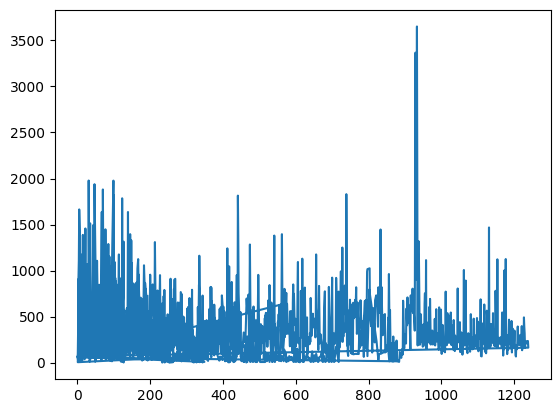

In [566]:
se_text_len.plot()

In [567]:
df_elements.query("type == 'NarrativeText'").query("len < 75").head(20)

,id,text,type,len,page_number,source,main_lang,element_number,parent_id
3,4d08e6af924ec4f2d8c3ad7f202b970d,1Illuin Technology 2Equall.ai,NarrativeText,29,1,colpali.pdf,eng,3,None
4,808d2178a8a4651d5ee1e1e29ad01aa3,"3CentraleSupélec, Paris-Saclay 4ETH Zürich",NarrativeText,42,1,colpali.pdf,eng,4,None
5,aba79745a3d38d700b7d47d350cf3497,manuel.faysse@centralesupelec.fr,NarrativeText,32,1,colpali.pdf,eng,5,None
7,f6400ed438b4f408567b16f722798490,4 2 0 2 l u J 2 ] R I . s c [ 2 v 9 4 4 1 0 . ...,NarrativeText,65,1,colpali.pdf,eng,7,None
13,8d7683b747174e024cd442b0d49236de,*Equal Contribution,NarrativeText,19,1,colpali.pdf,eng,13,f269905ccb21c63a052b96e7040e0806
68,7aaa5ad6728609cd0dc97fe6807e8609,7https://huggingface.co/google/ siglip-so400m-...,NarrativeText,57,6,colpali.pdf,eng,68,8b858e2d33962a85c032f4ed047386bb
91,410557673809c868a83e9806b8eae849,and inference time.,NarrativeText,19,8,colpali.pdf,eng,91,a631d7e3c0b99d2d9460cabf7d9e4fc3
102,6faddd6e8f36330f9769c9f29e4a57d6,"13Vespa Engine, RAGatouille, QDrant, colbert.ai",NarrativeText,47,9,colpali.pdf,eng,102,26735404e7e7c7b952328b532cfb1309
110,41fe9ed5b3ea647c46f7ecaeb8d587c5,Anthropic. 2024. The Claude 3 Model Family: Op...,NarrativeText,64,9,colpali.pdf,eng,110,5f05d3c8b2f544b0c270e3ef6d3557ea
111,12bc88f9797c268e8ac6689b53fe668c,14https://huggingface.co/spaces/vidore/ vidore...,NarrativeText,58,9,colpali.pdf,eng,111,5f05d3c8b2f544b0c270e3ef6d3557ea


# Chunks

In [575]:
df_titles_by_source = pd.concat(
    {source: pd.DataFrame(data) for source, data in dc_titles_by_source.items()},
    axis=0,
    names=["source"]
).reset_index()

df_titles_by_source.head(2)

,source,level_1,id,page,title,number,parent_title_id
0,colpali.pdf,0,f511938b5e0cde9b60b2daa56ff54d8d,1,ColPali: Efficient Document Retrieval with Vis...,None,None
1,colpali.pdf,1,e315a97e6b65c26710e269a0c6e6fa72,1,Abstract,None,f511938b5e0cde9b60b2daa56ff54d8d


In [40]:
import tiktoken

encoding = tiktoken.encoding_for_model(llm_model)


In [634]:
from langchain_core.documents.base import Document
from collections import Counter
import tiktoken

encoding = tiktoken.encoding_for_model(llm_model)

def chunk_elements(df_elements, df_titles_by_source):
    df_documents = (df_elements
                    .query("type == 'NarrativeText' & len> 75 ")
                    .groupby(['source', 'parent_id'])["text"]
                    .agg(lambda grp: "\n".join(grp))
                    .reset_index()
                    .merge(
                        df_titles_by_source.set_index(['id', 'source'])['title'],
                        how="left",
                        left_on=["source","parent_id"],
                        right_on=["source", "id"]
                    )
                    .merge(
                        df_elements.groupby(["source", "parent_id"])["element_number"].min(),
                        how="left",
                        on=["source", "parent_id"]
                    )
                    .merge(
                        df_elements.groupby(["source", "parent_id"])["page_number"].agg(lambda grp: list(set(grp))),
                        how="left",
                        on=["source", "parent_id"]
                    )
                    .merge(
                        df_elements.groupby(["source", "parent_id"])["main_lang"].agg(
                            lambda grp: Counter(grp).most_common(1)[0][0]),
                        how="left",
                        on=["source", "parent_id"]
                    )
                    .sort_values(by=["source", "element_number"])
    
                   )
    df_documents['title'] = df_documents['title'].fillna("")
    df_documents['content'] = df_documents.apply(lambda row: row['title'] + "\n" + row['text'], axis=1)
    df_documents['len'] = df_documents['content'].apply(len)
    df_documents['pages'] = df_documents['page_number'].apply(lambda x: f"{x[0]}-{x[-1]}" if len(x)>1 else str(x[0]))
    df_documents['num_pages'] = df_documents['page_number'].apply(len)

    return df_documents.drop(columns=["page_number"])

df_documents = chunk_elements(df_elements, df_titles_by_source)
df_documents['n_tokens'] = df_documents['content'].apply(lambda x: len(encoding.encode(x)))

df_documents.head()

,source,parent_id,text,title,element_number,main_lang,content,len,pages,num_pages,n_tokens
25,colpali.pdf,e315a97e6b65c26710e269a0c6e6fa72,Documents are visually rich structures that co...,Abstract,9,eng,Abstract\nDocuments are visually rich structur...,1187,1,1,233
26,colpali.pdf,f269905ccb21c63a052b96e7040e0806,Document Retrieval consists in matching a user...,Introduction,11,eng,Introduction\nDocument Retrieval consists in m...,3181,1-2,2,656
15,colpali.pdf,62d13c67a76e05aa1ba8eb512167d3fd,"Problem Setting. In our setting, a retrieval s...",2 Problem Formulation & Related Work,25,eng,2 Problem Formulation & Related Work\nProblem ...,1352,2-3,2,282
5,colpali.pdf,2ec51fb1abf88787d77ef41e9544e06b,Document Retrieval in Text Space. Statistical ...,2.1 Textual Retrieval Methods,30,eng,2.1 Textual Retrieval Methods\nDocument Retrie...,2199,2-3,2,458
7,colpali.pdf,335ee2c0f4dc351ea1f8d41e4f264de2,Contrastive Vision Language Models. Mapping la...,2.2 Integrating Visual features,33,eng,2.2 Integrating Visual features\nContrastive V...,1991,3,1,497


In [627]:
df_documents["n_tokens"].describe()

count      214.000000
mean       856.976636
std       2183.771178
min         23.000000
25%        204.000000
50%        376.000000
75%        803.000000
max      24516.000000
Name: n_tokens, dtype: float64

In [633]:
df_documents.info()

<class 'pandas.core.frame.DataFrame'>
Index: 214 entries, 25 to 213
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   source          214 non-null    object
 1   parent_id       214 non-null    object
 2   text            214 non-null    object
 3   title           214 non-null    object
 4   element_number  214 non-null    int64 
 5   main_lang       214 non-null    object
 6   content         214 non-null    object
 7   len             214 non-null    int64 
 8   pages           214 non-null    object
 9   num_pages       214 non-null    int64 
 10  n_tokens        214 non-null    int64 
dtypes: int64(4), object(7)
memory usage: 20.1+ KB


In [635]:

df_documents.to_parquet(path_unstructured / "docs-clean.parquet")

In [7]:
df_documents = pd.read_parquet(path_unstructured / "docs-clean.parquet")
df_documents.head(2)

,source,parent_id,text,title,element_number,main_lang,content,len,pages,num_pages,n_tokens
25,colpali.pdf,e315a97e6b65c26710e269a0c6e6fa72,Documents are visually rich structures that co...,Abstract,9,eng,Abstract\nDocuments are visually rich structur...,1187,1,1,233
26,colpali.pdf,f269905ccb21c63a052b96e7040e0806,Document Retrieval consists in matching a user...,Introduction,11,eng,Introduction\nDocument Retrieval consists in m...,3181,1-2,2,656


In [14]:
df_documents[['n_tokens', 'len']].describe().T

,count,mean,std,min,25%,50%,75%,max
n_tokens,214.0,856.976636,2183.771178,23.0,204.00,376.0,803.0,24516.0
len,214.0,3485.247664,7464.124213,91.0,877.25,1752.5,3418.5,82467.0


<Axes: ylabel='Frequency'>

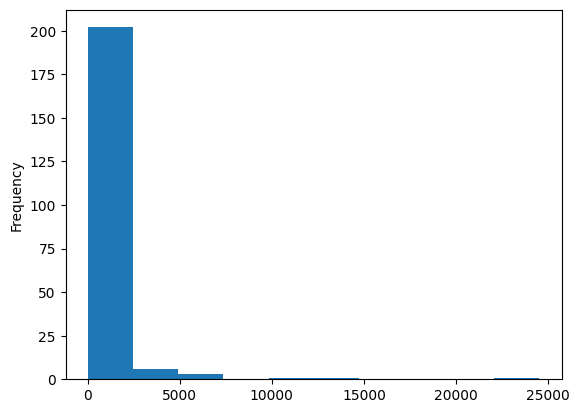

In [8]:
df_documents['n_tokens'].plot.hist()

In [11]:
df_documents.sort_values(by="n_tokens", ascending=False).head(10)

,source,parent_id,text,title,element_number,main_lang,content,len,pages,num_pages,n_tokens
143,llama3herd.pdf,ec80f42fb766435c35a9e2fa64fc8e64,"Amro Abbas, Kushal Tirumala, Dániel Simig, Sur...",References,941,eng,"References\nAmro Abbas, Kushal Tirumala, Dánie...",82467,75-92,18,24516
193,paligemma.pdf,87c7463b1dcf022ff5181ed1fb3e1380,"[1] M. Acharya, K. Kafle, and C. Kanan. Tal- l...",References,233,eng,"References\n[1] M. Acharya, K. Kafle, and C. K...",38967,14-26,13,14292
213,timesfm.pdf,066bae156e29e17fd18354f79e830bf8,Abstract Motivated by recent advances in large...,A decoder-only foundation model for time-serie...,1,eng,A decoder-only foundation model for time-serie...,45802,1-13,13,11031
165,mamba.pdf,f13b432ed5b40cda360217ae114695c0,"[1] Martin Arjovsky, Amar Shah, and Yoshua Ben...",References,231,eng,"References\n[1] Martin Arjovsky, Amar Shah, an...",24928,17-23,7,7146
154,mamba.pdf,1267584c9dbf8d57caa4acc6809e1cea,E.1 Synthetic Tasks Selective Copying. Our set...,E Experimental Details and Additional Results,441,eng,E Experimental Details and Additional Results\...,21362,32-31,8,5201
163,mamba.pdf,bafcad064a1bf1fca8bdd709be8e60ae,In Section 4.1 we test Mamba’s ability to solv...,4 Empirical Evaluation,114,eng,4 Empirical Evaluation\nIn Section 4.1 we test...,21635,10-17,8,5093
14,colpali.pdf,5f05d3c8b2f544b0c270e3ef6d3557ea,"Ibrahim Alabdulmohsin, Xiaohua Zhai, Alexander...",References,108,eng,"References\nIbrahim Alabdulmohsin, Xiaohua Zha...",13211,9-12,4,4116
36,lagllama.pdf,37ec83d88cb973475e259a889af21638,"Chen, S. Beijing Multi-Site Air-Quality Data. ...",Lag-Llama,161,eng,"Lag-Llama\nChen, S. Beijing Multi-Site Air-Qua...",9524,11-13,3,3171
162,mamba.pdf,ac826e2bfb341f0a9d33d901bf016470,The selection mechanism is designed to overcom...,3.3.2 Overview of Selective Scan: Hardware-Awa...,79,eng,3.3.2 Overview of Selective Scan: Hardware-Awa...,11650,8-7,3,2902
123,llama3herd.pdf,bb0a7a3b7571acb4ae166aebb87e7ee0,We first highlight Llama 3’s general behavior ...,5.4.4 Safety Results,584,eng,5.4.4 Safety Results\nWe first highlight Llama...,14088,44-48,5,2748


In [27]:
df_documents.head(2)

,source,parent_id,text,title,element_number,main_lang,content,len,pages,num_pages,n_tokens
25,colpali.pdf,e315a97e6b65c26710e269a0c6e6fa72,Documents are visually rich structures that co...,Abstract,9,eng,Abstract\nDocuments are visually rich structur...,1187,1,1,233
26,colpali.pdf,f269905ccb21c63a052b96e7040e0806,Document Retrieval consists in matching a user...,Introduction,11,eng,Introduction\nDocument Retrieval consists in m...,3181,1-2,2,656


In [95]:
from langchain_core.documents.base import Document

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2048,
    chunk_overlap=128,
    length_function=len,
    separators=["\n\n", "\n"],
    is_separator_regex=False,
)

lst_docs_corpus = [] 
lst_chunks_skipped = []
uuids = []

for idx, row in df_documents.iterrows():
    raw_content = row['content']
    lst_chunks = text_splitter.split_text(raw_content)
    
    for i, text_chunk in enumerate(lst_chunks):
        uuid = f"{row['source']}-{row['title']}-{row['element_number']}-{i+1}"
        n_tokens = len(encoding.encode(text_chunk))
        if n_tokens >= 10:
            doc = Document(
                page_content=text_chunk,
                metadata={
                    "source": row['source'],
                    "chunk_number": i + 1,
                    "len": len(text_chunk),
                    "n_tokens": n_tokens,
                    "parent_num_pages": row['num_pages'],
                    "parent_pages": row['pages'],
                    "parent_len": row['len'],
                    "parent_n_tokens": row['n_tokens'],
                    "parent_main_lan": len(row['main_lang']),
                    "parent_idx": idx
                }
            )
            lst_docs_corpus.append(doc)
            uuids.append(uuid)  
        else:
            lst_chunks_skipped.append((idx, i, n_tokens, text_chunk))

se_n_tokens = pd.Series([doc.metadata['n_tokens'] for doc in lst_docs_corpus])

print("Input number of documents", len(df_documents))
print("Output number of documents", len(lst_docs_corpus))
print("Number of skipped chunks", len(lst_chunks_skipped))
print("Statistics:")
print(se_n_tokens.describe())

Input number of documents 214
Output number of documents 504
Number of skipped chunks 1
Statistics:
count     504.000000
mean      364.515873
std       173.445598
min        23.000000
25%       242.000000
50%       370.500000
75%       457.500000
max      1164.000000
dtype: float64


In [85]:
len(set(uuids)) == len(uuids)

True

# Index

In [88]:
vector_store = Chroma(
    collection_name=index_name,
    embedding_function=embeddings,
    persist_directory=path_db.as_posix()
)
#vector_store.delete(ids=uuids)

vector_store.add_documents(documents=lst_docs_corpus, ids=uuids)

['colpali.pdf-Abstract-9-1',
 'colpali.pdf-Introduction-11-1',
 'colpali.pdf-Introduction-11-2',
 'colpali.pdf-2 Problem Formulation & Related Work-25-1',
 'colpali.pdf-2.1 Textual Retrieval Methods-30-1',
 'colpali.pdf-2.1 Textual Retrieval Methods-30-2',
 'colpali.pdf-2.2 Integrating Visual features-33-1',
 'colpali.pdf-3 The ViDoRe Benchmark-37-1',
 'colpali.pdf-3.1 Benchmark Design-39-1',
 'colpali.pdf-3.1 Benchmark Design-39-2',
 'colpali.pdf-3.2 Assessing Current Systems-47-1',
 'colpali.pdf-3.2 Assessing Current Systems-47-2',
 'colpali.pdf-4.1 Architecture-55-1',
 'colpali.pdf-4.2 Model training-62-1',
 'colpali.pdf-5.1 Performance (R1)-67-1',
 'colpali.pdf-5.1 Performance (R1)-67-2',
 'colpali.pdf-5.2 Latencies & Memory Footprint-72-1',
 'colpali.pdf-5.2 Latencies & Memory Footprint-72-2',
 'colpali.pdf-5.3 Interpretability-82-1',
 'colpali.pdf-6 Ablation study-84-1',
 'colpali.pdf-6 Ablation study-84-2',
 'colpali.pdf-7 Conclusions-96-1',
 'colpali.pdf-Limitations-99-1',
 'co

# Test Query

In [89]:
results = vector_store.similarity_search(
    "how many datasets are used to train lag-llama?",
    k=2
)
for res in results:
    print(f"* {res.page_content[:100]} [{res.metadata}]")
    print()

* D. Hyperparameters of Lag-Llama
We perform a random search of 100 different hyperparame- ter configu [{'chunk_number': 1, 'len': 411, 'n_tokens': 86, 'parent_idx': 45, 'parent_len': 411, 'parent_main_lan': 3, 'parent_n_tokens': 86, 'parent_num_pages': 1, 'parent_pages': '17', 'source': 'lagllama.pdf'}]

* B. Protocol Details
For all datasets used in the paper, we have a training and test split that are n [{'chunk_number': 1, 'len': 1761, 'n_tokens': 383, 'parent_idx': 52, 'parent_len': 1761, 'parent_main_lan': 3, 'parent_n_tokens': 383, 'parent_num_pages': 3, 'parent_pages': '16-15', 'source': 'lagllama.pdf'}]



In [92]:

retriever = vector_store.as_retriever(
    search_type="similarity_score_threshold", search_kwargs={"score_threshold":retriever_treshold, "k": retriever_k})
chain_basic_rag = chain.rag_basic_with_sources(llm , retriever)
response = chain_basic_rag.invoke({'input': "how many time series datasets are used to train lag-llama model?"})

print("Context:")
for context in response['context']:
    print(f"text: {context.page_content[:100]}")
    print(f"metadata: {res.metadata}")
    print()
    
print("Answer: ", response['answer'])

Context:
text: datasets are encountered downstream with different levels of data history being available, and show 
metadata: {'chunk_number': 1, 'len': 1761, 'n_tokens': 383, 'parent_idx': 52, 'parent_len': 1761, 'parent_main_lan': 3, 'parent_n_tokens': 383, 'parent_num_pages': 3, 'parent_pages': '16-15', 'source': 'lagllama.pdf'}

text: 4.5. Training Strategies
We employ a series of training strategies to effectively pre- train Lag-Lla
metadata: {'chunk_number': 1, 'len': 1761, 'n_tokens': 383, 'parent_idx': 52, 'parent_len': 1761, 'parent_main_lan': 3, 'parent_n_tokens': 383, 'parent_num_pages': 3, 'parent_pages': '16-15', 'source': 'lagllama.pdf'}

Answer:  No relevant information has been founded related to that question, please provide a more specific one.


In [97]:
fln_eval_ds

WindowsPath('c:/users/manua/documents/repos/dslabs/rag-advanced/data/raw/eval-questions/ai-papers-2.0.csv')

In [101]:
split_label = mle_utils.Splits.TRAIN.value



df_eval_qs = (pd.read_csv(fln_eval_ds)
              .query(f"{tags.SPLIT} == '{split_label}'"))
df_eval_qs

,paper,question,ground_truth,source,split_
0,Mamba: Linear-Time Sequence Modeling with Sele...,What are the main limitations and risks associ...,While Mamba shows strong performance in variou...,Section 5,1.train
1,PaliGemma,How does PaliGemma perform compared to larger ...,"PaliGemma, with less than 3B parameters, achie...","Introduction, Section 1; Results, Section 4",1.train
2,Llama 3,What ablation studies were conducted on Llama ...,Ablation studies focused on hyperparameters li...,"Ablation Studies, Section 5",1.train
3,Mamba: Linear-Time Sequence Modeling with Sele...,What is the hardware optimization that enables...,Mamba uses a hardware-aware parallel algorithm...,"Abstract, Section 3.3",1.train
4,PaliGemma,How does PaliGemma achieve transferability acr...,PaliGemma uses a flexible fine-tuning approach...,"Transferability, Section 6",1.train
5,Lag-Llama,What is the choice of the distribution head us...,The model uses a Student's t-distribution head...,Section 4.3: Choice of Distribution Head,1.train
6,Lag-Llama,What datasets were used to train and evaluate ...,The model was trained on 27 datasets across do...,Section 5.1: Datasets,1.train
7,ColPali,How does ColPali achieve faster indexing and q...,ColPali directly encodes pages from their imag...,"Section 5.2, Latencies & Memory Footprint",1.train
8,TimesFM,How does TimesFM handle long-horizon forecasts...,TimesFM uses longer output patches during deco...,"Model Architecture, Section 4",1.train
9,TimesFM,What novelties does the TimesFM introduce in t...,The main novelties include a patched-decoder s...,"Abstract, Introduction, Model Architecture",1.train


In [ ]:
dataset = rag_eval.populate_eval_dataset(df_eval_qs, chain_basic_rag)

# https://www.databricks.com/blog/LLM-auto-eval-best-practices-RAG
# https://docs.ragas.io/en/latest/references/evaluation.htmlS

In [109]:
metrics = [
            context_relevancy,
            context_precision,
            context_recall,
            faithfulness,
            answer_relevancy,
        ]

In [112]:
with open(fln_eval_ragas, "wb") as file:
    pickle.dump(res_ragas_eval, file)

In [113]:
if fln_eval_ragas.exists():
    with open(fln_eval_ragas, "rb") as file:
        res_ragas_eval = pickle.load(file)

else:  
    res_ragas_eval = evaluate(
        dataset=dataset,
        metrics=[
            context_relevancy,
            context_precision,
            context_recall,
            faithfulness,
            answer_relevancy,
        ],
        llm=llm_eval,
        embeddings=embeddings
    )
    

    with open(fln_eval_ragas, "wb") as file:
        pickle.dump(res_ragas_eval, file)

# 01-basic: 
#{'context_relevancy': 0.0325, 'context_precision': 0.7500, 'context_recall': 0.5278, 'faithfulness': 0.5625, 'answer_relevancy': 0.5502}
res_ragas_eval

{'context_relevancy': 0.1639, 'context_precision': 0.8333, 'context_recall': 0.6250, 'faithfulness': 0.6816, 'answer_relevancy': 0.6925}

In [115]:
df_ragas_eval = res_ragas_eval.to_pandas()
df_ragas_eval.head(2)

,question,answer,contexts,ground_truth,context_relevancy,context_precision,context_recall,faithfulness,answer_relevancy
0,What are the main limitations and risks associ...,No relevant information has been founded relat...,[• Language Modeling. Mamba is the first linea...,While Mamba shows strong performance in variou...,0.062500,0.0,0.0,0.0,0.000000
1,How does PaliGemma perform compared to larger ...,"PaliGemma, despite being a smaller model with ...","[8. Conclusion\nPaliGemma is a new, small, ope...","PaliGemma, with less than 3B parameters, achie...",0.214286,1.0,0.5,1.0,0.813011


In [114]:
from langfuse import Langfuse

langfuse = Langfuse()
langfuse.auth_check()

True

In [118]:
df_ragas_eval_traces = rag_eval.trace_evaluation(
    langfuse,
    f"{id_pipeline}_ragas",
    df_ragas_eval,
    [metric.name for metric in metrics]
)
